# **Near Field Scan Script for Aaron's Quickturn Antenna**

Tunes antenna using two Arduinos + two DAC boards

### Import modules

In [1]:
import sys
sys.path.append(r'C:/Users/smithlab/Documents/Acquisition-Code/Modules')
import numpy as np
from matplotlib import pyplot as plt
import VNA_control as vc
import stage_control as sc
import probe_deconvolve as pd
import propagation_functions as pf
import scipy.constants
import scipy.io
import time
import datetime
import mainPyDAC2_module_multiple_Aaron as tune
import pin_mappings as pm
import numpy.matlib

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

### Tuning state generation

In [3]:
# voltage_list = np.linspace(0, 5, 21)

# ts = []
# for i in range(len(element_pin_index)):
#     for j in range(len(voltage_list)):
#         t = np.zeros(240)
#         t[element_pin_index[i]] = voltage_list[j]
#         ts.append(t)

mat = scipy.io.loadmat(r'C:\Users\smithlab\Documents\Aaron\Tuning States\steering_test_22-06-08.mat')
element_voltages = mat['ts']

ts = pm.make_ts_quickturn(element_voltages)

### Test tuning state

In [3]:
# ts[10] = all 1V, ts[20] = all 2 V, ..., 
# ts[51]=1V element 1, ts[52]=1V element 2, ...,
# ts[212] = 2V element 1, ts[373] = 3V element 1, ...
# state = ts[51] 
# tune.testProgram30DAC(serial1, state)
# tune.testProgram30DAC(serial2, state)

### General scan parameters

In [7]:
a_probe = 22.86
b_probe = 10.16

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 9E9
fstop = 10E9
NumFreqs = 101
NumApMasks = len(ts)
f = np.linspace(fstart, fstop, NumFreqs)
lam_min = C/fstop
dstep = lam_min/2 * 1000 # mm

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0 # dBm
sParMeas = 'S12'
speedmms = 25       # don't change this

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


### Initialize instruments

In [89]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Arduino
numDACs = 30
serial1 = tune.initializeArduino(numDACs, "COM9")
serial2 = tune.initializeArduino(numDACs, "COM10")

## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, calfile=calfile)

READY
Received: 30 from serial.
READY
Received: 30 from serial.
Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



array([9.00e+09, 9.01e+09, 9.02e+09, 9.03e+09, 9.04e+09, 9.05e+09,
       9.06e+09, 9.07e+09, 9.08e+09, 9.09e+09, 9.10e+09, 9.11e+09,
       9.12e+09, 9.13e+09, 9.14e+09, 9.15e+09, 9.16e+09, 9.17e+09,
       9.18e+09, 9.19e+09, 9.20e+09, 9.21e+09, 9.22e+09, 9.23e+09,
       9.24e+09, 9.25e+09, 9.26e+09, 9.27e+09, 9.28e+09, 9.29e+09,
       9.30e+09, 9.31e+09, 9.32e+09, 9.33e+09, 9.34e+09, 9.35e+09,
       9.36e+09, 9.37e+09, 9.38e+09, 9.39e+09, 9.40e+09, 9.41e+09,
       9.42e+09, 9.43e+09, 9.44e+09, 9.45e+09, 9.46e+09, 9.47e+09,
       9.48e+09, 9.49e+09, 9.50e+09, 9.51e+09, 9.52e+09, 9.53e+09,
       9.54e+09, 9.55e+09, 9.56e+09, 9.57e+09, 9.58e+09, 9.59e+09,
       9.60e+09, 9.61e+09, 9.62e+09, 9.63e+09, 9.64e+09, 9.65e+09,
       9.66e+09, 9.67e+09, 9.68e+09, 9.69e+09, 9.70e+09, 9.71e+09,
       9.72e+09, 9.73e+09, 9.74e+09, 9.75e+09, 9.76e+09, 9.77e+09,
       9.78e+09, 9.79e+09, 9.80e+09, 9.81e+09, 9.82e+09, 9.83e+09,
       9.84e+09, 9.85e+09, 9.86e+09, 9.87e+09, 9.88e+09, 9.89e

### Configure save path

In [90]:
savename = 'Quickturn_Antenna_Elements_Voltage_Sweep_Close'
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'

### Scan

#### *Set scan lengths*

In [91]:
Lx_ap = 300
Ly_ap = 190
theta = 30
d = 82

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [92]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = 119  # adjust to change x zero position
pos_y = -30  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-381.0, -530.0)

#### *Set origin*

In [12]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [13]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

(-197.3426, -142.3426)

In [14]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        
        moved = None
        while moved is None:
            try:
                sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
                moved = True
            except:
                pass
        
        for jj in range(NumApMasks):
            tune.testProgram30DAC(serial1,ts[jj])
            tune.testProgram30DAC(serial2,ts[jj])
            time.sleep(0.01)
            measurements_x[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 13.134206922120518 hours
Est. time remaining: 12.79994360016452 hours
Est. time remaining: 12.532675577203433 hours
Est. time remaining: 12.271628258095847 hours
Est. time remaining: 12.01182182709376 hours
Est. time remaining: 11.752814774711927 hours
Est. time remaining: 11.489521058400472 hours
Est. time remaining: 11.232323490513696 hours
Est. time remaining: 10.970208350419998 hours
Est. time remaining: 10.696396641068988 hours
Est. time remaining: 10.452597968710794 hours
Est. time remaining: 10.211593901117643 hours
Est. time remaining: 9.944035976396666 hours
Est. time remaining: 9.669184034201834 hours
Est. time remaining: 9.431125573913256 hours
Est. time remaining: 9.170415543384022 hours
Est. time remaining: 8.881264619363678 hours
Est. time remaining: 8.646104061007499 hours
Est. time remaining: 8.382615884741147 hours
Est. time remaining: 8.12470649878184 hours
Est. time remaining: 7.867857479850451 hours
Est. time remaining: 7.6051727406846155 hours


(Theta_s, Phi_s) = (60, 180)


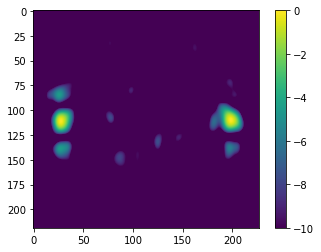

In [83]:
f_indx = np.argmin(np.abs(f - 9.75E9))

m_indx = 58
print('(Theta_s, Phi_s) = ({}, {})'.format(mat['Theta_s'][0,m_indx], mat['Phi_s'][0,m_indx]))

measurement_pad = np.pad(measurements_x[:,:,f_indx,m_indx], 100)
im = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(measurement_pad, axes=(0,1)), axes=(0,1)), axes=(0,1))

plt.figure()
plt.imshow(20*np.log10(np.abs(im)/np.amax(np.abs(im))))
plt.colorbar()
plt.clim(-10, 0)
plt.show()

In [42]:
m_indx = 18
print(mat['Theta_s'][0,m_indx])
print(mat['Phi_s'][0,m_indx])

15
150


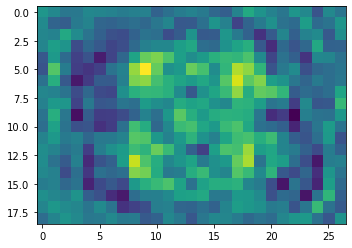

In [84]:
plt.imshow(np.real(measurements_x[:,:,f_indx,6]))

#### *Start scan - y-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [40]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram30DAC(serial1,ts[jj])
            tune.testProgram30DAC(serial2,ts[jj])
            time.sleep(0.01)
            measurements_y[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 264.4011574104097 hours
Est. time remaining: 261.0154204874569 hours
Est. time remaining: 257.6186923336983 hours
Est. time remaining: 254.1380053869883 hours
Est. time remaining: 250.81464299586085 hours
Est. time remaining: 247.40609361410142 hours


KeyboardInterrupt: 

#### *Concatenate measurements*

In [85]:
measurements = np.stack((measurements_x, measurements_y), axis=4)

### Probe compensation

In [86]:
# measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks, 2), dtype=np.complex128)

# for i in range(NumFreqs):

#     A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

#     for j in range(NumApMasks):

#         measurements_corrected[:,:,i,j,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,j,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
        
measurements_corrected = measurements    # TEMP, UNTIL PROBE CORRECTION IS SOLVED
    

### Plot

In [87]:
measurements.shape

(19, 27, 101, 65, 2)

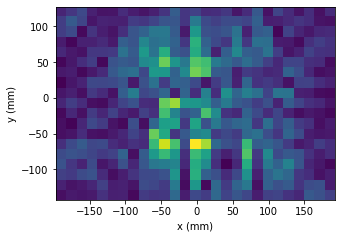

In [61]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements[:,:,f_indx,m_indx,0]), extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()


### Save data

In [88]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'Lx_ap': Lx_ap,
                                       'Ly_ap': Ly_ap,
                                       'f': f,
                                       'ts': ts,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected})

In [49]:
measurements.shape

(24, 33, 101, 856, 2)

In [51]:
len(ts)

856